In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
# Load and preprocess data
cwd = os.getcwd()
cwd = '/'.join(cwd.split('/')[:-1])


file_path = 'C:/Users/rishe/Buy-vs-Rent/Datasets/home_value_index_co.pkl'
region = 'Boulder'
df = pd.read_pickle(file_path)

In [5]:

# Filter data for the specific region
region_data = df[df['RegionName'] == region]['home_value_index'].values[0]

# Create a date range
date_range = pd.date_range(start='2000-01-31', freq='M', periods=len(region_data))

# Prepare DataFrame
df_region = pd.DataFrame({'ds': date_range, 'y': region_data})
values = df_region['y'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)

# Set training cutoff date
train_cutoff_date = '2022-12-31'
train_size = len(df_region[df_region['ds'] <= train_cutoff_date])

# Split data into training and testing sets based on date
train = scaled_data[:train_size]
test = scaled_data[train_size:]

# Create supervised learning dataset
look_back = 12
X_train, y_train = [], []
X_test, y_test = [], []


C:\Users\rishe\AppData\Local\Temp\ipykernel_62280\3185690676.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2000-01-31', freq='M', periods=len(region_data))


In [6]:
# Prepare training data
for i in range(len(train) - look_back):
    X_train.append(train[i:i + look_back, 0])
    y_train.append(train[i + look_back, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare test data
for i in range(len(test) - look_back):
    X_test.append(test[i:i + look_back, 0])
    y_test.append(test[i + look_back, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=8, verbose=1)

c:\Users\rishe\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0635
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011   
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3426e-04
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3115e-04
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5639e-04
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9729e-04
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9202e-04
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5393e-04
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3054e-04
Epoch 10/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2238e-04
Epoch 11/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3757e-04
Epoch 12/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6076e-04
Epoch 13/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5947e-04
Epoch 14/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0399e-04
Epoch 15/500
33/33 ━

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


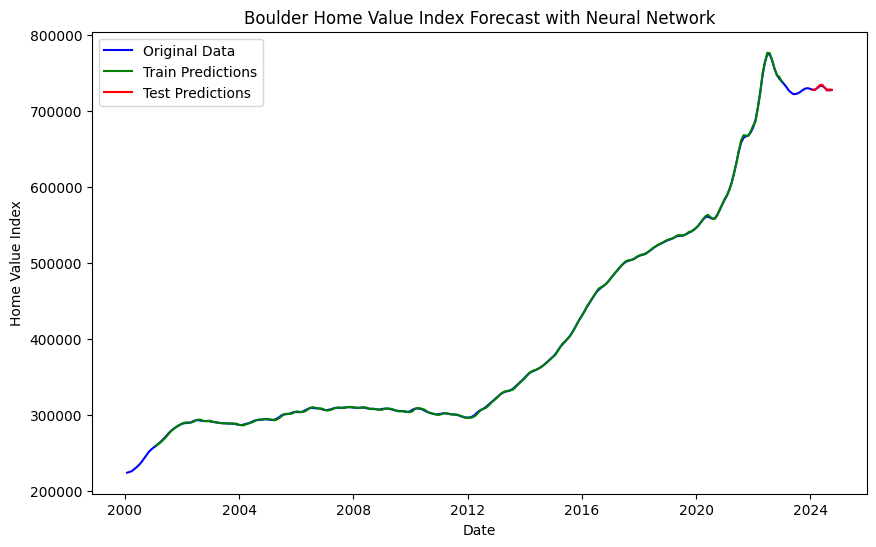


Accuracy Metrics:
MAPE: 0.12%
MAE: 852.49


In [7]:
# Forecast future values
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = scaler.inverse_transform(predicted_test)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_region['ds'], values, label='Original Data', color='blue')
plt.plot(df_region['ds'][look_back:train_size], predicted_train, label='Train Predictions', color='green')
plt.plot(df_region['ds'][train_size + look_back:], predicted_test, label='Test Predictions', color='red')
plt.title(f'{region} Home Value Index Forecast with Neural Network')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Calculate accuracy metrics
mape = mean_absolute_percentage_error(y_test_actual, predicted_test) * 100
mae = mean_absolute_error(y_test_actual, predicted_test)

print("\nAccuracy Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

In [8]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = mean_squared_error(y_test_actual, predicted_test, squared=False)

print("\nAccuracy Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



Accuracy Metrics:
MAPE: 0.12%
MAE: 852.49
RMSE: 994.84


c:\Users\rishe\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
